![](yelp_logo.jpg)

# Yelp Dataset Exploration

In [1]:
!ls

Dataset_Challenge_Dataset_Agreement.pdf
Yelp_Dataset_Challenge_Terms_round_9.pdf
force.json
networks.ipynb
yelp_academic_dataset_business.json
yelp_academic_dataset_checkin.json
yelp_academic_dataset_review.json
yelp_academic_dataset_tip.json
yelp_academic_dataset_user.json
yelp_exploration.ipynb
yelp_logo.jpg


## Business Dataset

### File characteristics

In [2]:
!ls -l -h yelp_academic_dataset_business.json

-rw-r--r--@ 1 luiscastro  staff   109M Jan 20 13:15 yelp_academic_dataset_business.json


In [3]:
!head -n 1 yelp_academic_dataset_business.json

{"business_id":"0DI8Dt2PJp07XkVvIElIcQ","name":"Innovative Vapors","neighborhood":"","address":"227 E Baseline Rd, Ste J2","city":"Tempe","state":"AZ","postal_code":"85283","latitude":33.3782141,"longitude":-111.936102,"stars":4.5,"review_count":17,"is_open":0,"attributes":["BikeParking: True","BusinessAcceptsBitcoin: False","BusinessAcceptsCreditCards: True","BusinessParking: {'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}","DogsAllowed: False","RestaurantsPriceRange2: 2","WheelchairAccessible: True"],"categories":["Tobacco Shops","Nightlife","Vape Shops","Shopping"],"hours":["Monday 11:0-21:0","Tuesday 11:0-21:0","Wednesday 11:0-21:0","Thursday 11:0-21:0","Friday 11:0-22:0","Saturday 10:0-22:0","Sunday 11:0-18:0"],"type":"business"}


In [4]:
!wc -l yelp_academic_dataset_business.json

  144072 yelp_academic_dataset_business.json


### Data loading

In [5]:
import json

with open('yelp_academic_dataset_business.json') as f:
    data = [json.loads(line) for line in f]

In [6]:
import pandas as pd

df = pd.DataFrame(data)
df.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state,type
0,"227 E Baseline Rd, Ste J2","[BikeParking: True, BusinessAcceptsBitcoin: Fa...",0DI8Dt2PJp07XkVvIElIcQ,"[Tobacco Shops, Nightlife, Vape Shops, Shopping]",Tempe,"[Monday 11:0-21:0, Tuesday 11:0-21:0, Wednesda...",0,33.378214,-111.936102,Innovative Vapors,,85283,17,4.5,AZ,business
1,495 S Grand Central Pkwy,"[BusinessAcceptsBitcoin: False, BusinessAccept...",LTlCaCGZE14GuaUXUGbamg,"[Caterers, Grocery, Food, Event Planning & Ser...",Las Vegas,"[Monday 0:0-0:0, Tuesday 0:0-0:0, Wednesday 0:...",1,36.192284,-115.159272,Cut and Taste,,89106,9,5.0,NV,business
2,979 Bloor Street W,"[Alcohol: none, Ambience: {'romantic': False, ...",EDqCEAGXVGCH4FJXgqtjqg,"[Restaurants, Pizza, Chicken Wings, Italian]",Toronto,"[Monday 11:0-2:0, Tuesday 11:0-2:0, Wednesday ...",1,43.661054,-79.429089,Pizza Pizza,Dufferin Grove,M6H 1L5,7,2.5,ON,business
3,7014 Steubenville Pike,"[AcceptsInsurance: False, BusinessAcceptsCredi...",cnGIivYRLxpF7tBVR_JwWA,"[Hair Removal, Beauty & Spas, Blow Dry/Out Ser...",Oakdale,"[Tuesday 10:0-21:0, Wednesday 10:0-21:0, Thurs...",1,40.444544,-80.174540,Plush Salon and Spa,,15071,4,4.0,PA,business
4,321 Jarvis Street,"[BusinessAcceptsCreditCards: True, Restaurants...",cdk-qqJ71q6P7TJTww_DSA,"[Hotels & Travel, Event Planning & Services, H...",Toronto,None,1,43.659829,-79.375401,Comfort Inn,Downtown Core,M5B 2C2,8,3.0,ON,business


In [7]:
df = df[['business_id','name','city','state','latitude','longitude','review_count','stars']]

Column selection will be needed to isolate features to be transformed or analyzed, create a transformer for it.

In [8]:
from sklearn          import base
from sklearn.pipeline import Pipeline

class ColumnSelector(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, col_names):
        self.col_names = col_names
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return [[row[self.col_names]] for row in X]

Other useful transformers will help transform lists into dictionaries and flatten nested dictionaries.

In [9]:
class DictEncoder(base.BaseEstimator, base.TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        result = []
        
        for i in X:
            temp = {}
            if i[0] != None:
                for j in i[0]:
                    temp[j] = 1
                    
            result.append(temp)
            
        return result

### Categories

In [10]:
from sklearn.feature_extraction import DictVectorizer
cst = ColumnSelector('categories')
DV = DictVectorizer(sparse=False)
DV.fit(DictEncoder().fit_transform(cst.transform(data)))

DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=False)

In [11]:
categories = pd.DataFrame(DV.transform(DictEncoder().fit_transform(cst.transform(data))),columns=DV.feature_names_,index=df.index)

In [12]:
restaurants = df.ix[categories['Restaurants']==1]

In [13]:
import re

class DictEncoder2(base.BaseEstimator, base.TransformerMixin):
    def __init__(self,column):
        self.column = column
    
    def fit(self, X, y=None):
        return self
        
    def transform(self,X):
        
        result = []
        
        for n in range(len(X)):
            
            temp_dic = {}
            
            if X[n][self.column] is not None:
                for i in X[n][self.column]:
                    temp = i.split(':')
                    temp0 = temp[0]
                    temp1 = temp[1:]

                    if len(temp1) == 1:
                        temp1[0] = temp1[0].strip().strip(',')
                        if str(temp1[0]).lower() == 'false' or temp1[0] == '0' or str(temp1[0]).lower() == 'no' or str(temp1[0]).lower() == 'none':
                            temp1[0] = 0
                        if str(temp1[0]).lower() == 'true' or temp1[0] == '1' or str(temp1[0]).lower() == 'yes':
                            temp1[0] = 1
                        if len(str(temp1[0])) > 1:
                            temp0    = temp0+str(temp1[0])
                            temp1[0] = 1
                        
                        temp_dic.update({temp0.strip():int(temp1[0])})

                    else:
                        temp3 = []
                        for j in temp1:
                            temp3.append(re.sub('{|}|\'','',j).split())
                        temp3 = [item for sublist in temp3 for item in sublist]

                        for k in range(0,len(temp3)-1,2):
                            temp3[k+1] = temp3[k+1].strip().strip(',')
                            if str(temp3[k+1]).lower() == 'false' or temp3[k+1] == '0' or str(temp3[k+1]).lower() == 'no' or str(temp3[k+1]).lower() == 'none':
                                temp3[k+1] = 0
                            if str(temp3[k+1]).lower() == 'true' or temp3[k+1] == '1' or str(temp3[k+1]).lower() == 'yes':
                                temp3[k+1] = 1
                            if len(str(temp3[k+1])) > 1:
                                temp3[k]    = temp3[k].strip()+str(temp3[k+1])
                                temp3[k+1]  = 1

                            temp_dic.update({temp3[k].strip():int(temp3[k+1])})
            else:
                temp_dic.update({})
        
            result.append(temp_dic)
        return result   

### Attributes

In [14]:
DV = DictVectorizer(sparse=False)
DV.fit(DictEncoder2('attributes').transform(data))

DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=False)

In [15]:
attributes = pd.DataFrame(DV.transform(DictEncoder2('attributes').fit_transform(data)),columns=DV.feature_names_,index=df.index)

In [16]:
restaurants_att = attributes.ix[categories['Restaurants']==1]

In [17]:
restaurants_att = restaurants_att.loc[:,restaurants_att.std()>0.0]

In [18]:
result = pd.concat([restaurants,restaurants_att], axis=1, join_axes=[restaurants.index])

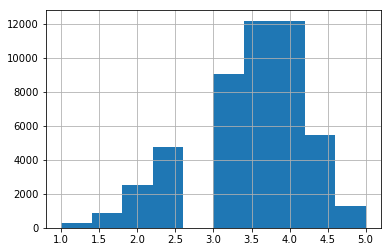

In [19]:
import matplotlib.pyplot as plt

result['stars'].hist()
plt.show()

In [20]:
len(result.columns)

100

In [21]:
result = result[[ 'stars','business_id', 'name', 'city', 'state',
       'review_count','latitude', 'longitude', 'AcceptsInsurance', 'AgesAllowed18plus',
       'AgesAllowed19plus', 'AgesAllowed21plus', 'AgesAllowedallages',
       'Alcoholbeer_and_wine', 'Alcoholfull_bar', 'BYOB',
       'BYOBCorkageyes_corkage', 'BYOBCorkageyes_free', 'BikeParking',
       'BusinessAcceptsBitcoin', 'BusinessAcceptsCreditCards',
       'ByAppointmentOnly', 'Caters', 'CoatCheck', 'Corkage', 'DogsAllowed',
       'DriveThru', 'GoodForDancing', 'GoodForKids', 'HappyHour', 'HasTV',
       'NoiseLevelaverage', 'NoiseLevelloud', 'NoiseLevelquiet',
       'NoiseLevelvery_loud', 'Open24Hours', 'OutdoorSeating',
       'RestaurantsAttirecasual', 'RestaurantsAttiredressy',
       'RestaurantsAttireformal', 'RestaurantsCounterService',
       'RestaurantsDelivery', 'RestaurantsGoodForGroups',
       'RestaurantsPriceRange2', 'RestaurantsReservations',
       'RestaurantsTableService', 'RestaurantsTakeOut', 'Smoking',
       'Smokingoutdoor', 'WheelchairAccessible', 'WiFifree', 'WiFipaid',
       'africanamerican', 'asian', 'background_music', 'breakfast', 'brunch',
       'casual', 'classy', 'coloring', 'curly', 'dairy-free', 'dessert',
       'dinner', 'divey', 'dj', 'extensions', 'friday', 'garage',
       'gluten-free', 'halal', 'hipster', 'intimate', 'jukebox', 'karaoke',
       'kids', 'kosher', 'latenight', 'live', 'lot', 'lunch', 'monday',
       'perms', 'romantic', 'saturday', 'soy-free', 'straightperms', 'street',
       'sunday', 'thursday', 'touristy', 'trendy', 'tuesday', 'upscale',
       'valet', 'validated', 'vegan', 'vegetarian', 'video', 'wednesday']]

In [22]:
stars = result['stars'].values

In [23]:
result.drop('stars',axis=1,inplace=True)

In [24]:
meta = result[['business_id','name','city','state','review_count']]

In [25]:
result.drop(['business_id','name','city','state','review_count'],axis=1,inplace=True)

In [26]:
result.head()

,latitude,longitude,AcceptsInsurance,AgesAllowed18plus,AgesAllowed19plus,AgesAllowed21plus,AgesAllowedallages,Alcoholbeer_and_wine,Alcoholfull_bar,BYOB,...,touristy,trendy,tuesday,upscale,valet,validated,vegan,vegetarian,video,wednesday
2,43.661054,-79.429089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,33.586710,-111.835410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,36.029596,-115.085821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,45.590227,-73.430235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,45.502346,-73.573807,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Pipelines, Feature Union and Hot One Encoding

In [27]:
from sklearn.pipeline           import FeatureUnion
from sklearn.feature_extraction import DictVectorizer

pipe1 = Pipeline([
    ('encoding',DictEncoder2('attributes')),
    ('vectorizing',DictVectorizer(sparse=False))
])

pipe2 = Pipeline([
    ('selecting',ColumnSelector('categories')),
    ('neighbors',DictEncoder()),
    ('vectorizing',DictVectorizer(sparse=False))
])

all_features = FeatureUnion([
    ('pipe1',pipe1),
    ('pipe2',pipe2),
])

### Predicting Rating

In [28]:
from sklearn.ensemble import ExtraTreesRegressor as ETR
#from sklearn.linear_model import Ridge
import numpy          as np

#ratings = [row['stars'] for row in data]
#train   = all_features.fit_transform(data)

clf = ETR()
clf.fit(result,stars)
np.mean(abs(clf.predict(result)-stars))

0.00047093602832491146

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(result,stars,test_size=0.25,random_state=0)

clf = ETR(n_jobs=2,bootstrap=True,n_estimators=20,criterion='mse')
clf.fit(X_train,y_train)

ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=20, n_jobs=2, oob_score=False, random_state=None,
          verbose=0, warm_start=False)

In [73]:
import pandas
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [72]:
result.shape

(48485, 94)

In [137]:
def baseline_model():
    model = Sequential()
    model.add(Dense(100, input_dim=94,init='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dropout(0.25))
    model.add(Dense(100,init='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dropout(0.25))
    model.add(Dense(1,init='he_normal'))
    model.compile(loss='mse',optimizer='Adamax')
    return model

In [138]:
import numpy

seed = 0
numpy.random.seed(seed)

estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=1000, batch_size=1000, verbose=2)

In [ ]:
kfold = KFold(n_splits=5, random_state=seed)
results = cross_val_score(estimator, result.values,stars, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [139]:
estimator.fit(X_train.values,y_train)

Epoch 1/1000
1s - loss: 10.4873
Epoch 2/1000
0s - loss: 6.0691
Epoch 3/1000
0s - loss: 2.7779
Epoch 4/1000
0s - loss: 1.6402
Epoch 5/1000
0s - loss: 1.4178
Epoch 6/1000
0s - loss: 1.3005
Epoch 7/1000
0s - loss: 1.2023
Epoch 8/1000
0s - loss: 1.1505
Epoch 9/1000
0s - loss: 1.0931
Epoch 10/1000
0s - loss: 1.0569
Epoch 11/1000
1s - loss: 1.0146
Epoch 12/1000
1s - loss: 0.9701
Epoch 13/1000
1s - loss: 0.9382
Epoch 14/1000
0s - loss: 0.9069
Epoch 15/1000
0s - loss: 0.8755
Epoch 16/1000
0s - loss: 0.8491
Epoch 17/1000
0s - loss: 0.8382
Epoch 18/1000
0s - loss: 0.8147
Epoch 19/1000
0s - loss: 0.7860
Epoch 20/1000
0s - loss: 0.7642
Epoch 21/1000
1s - loss: 0.7523
Epoch 22/1000
1s - loss: 0.7344
Epoch 23/1000
0s - loss: 0.7211
Epoch 24/1000
0s - loss: 0.7051
Epoch 25/1000
1s - loss: 0.6994
Epoch 26/1000
1s - loss: 0.6853
Epoch 27/1000
1s - loss: 0.6742
Epoch 28/1000
0s - loss: 0.6676
Epoch 29/1000
0s - loss: 0.6599
Epoch 30/1000
0s - loss: 0.6460
Epoch 31/1000
0s - loss: 0.6424
Epoch 32/1000
1s

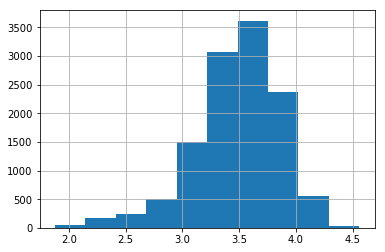

In [140]:
pd.Series(estimator.predict(X_test.values)).hist()
plt.show()

In [141]:
counts = pd.Series(stars).value_counts()
pd.DataFrame(counts.index,counts.values).sort_values(by=0)

,0
283,1.0
873,1.5
2489,2.0
4757,2.5
9036,3.0
12177,3.5
12141,4.0
5447,4.5
1282,5.0


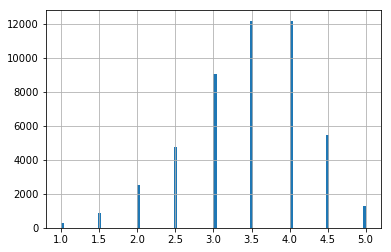

In [142]:
pd.Series(stars).hist(bins=100)
plt.show()

In [143]:
def rounder(x):
    decimal  = x-np.floor(x)
    x2r = np.floor(x) 
    
    if decimal < 0.25:
        return x2r
    elif decimal > 0.75:
        return x2r + 1
    else:
        return x2r + 0.5

In [144]:
rounder(3.9)

4.0

In [145]:
pd.Series(estimator.predict(X_test.values)).apply(rounder).value_counts()

3.5    6393
4.0    2959
3.0    2161
2.5     458
2.0     110
4.5      41
dtype: int64

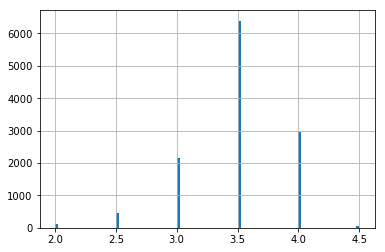

In [146]:
pd.Series(estimator.predict(X_test.values)).apply(rounder).hist(bins=100)
plt.show()

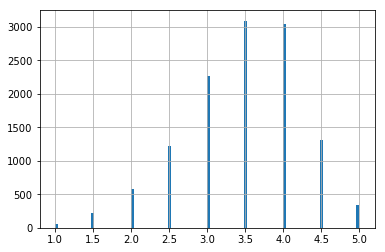

In [147]:
pd.Series(y_test).hist(bins=100)
plt.show()

In [156]:
sum(abs(y_test- pd.Series(estimator.predict(X_test.values))))/len(y_test)

0.54947655398820894

In [29]:
pd.DataFrame(clf.feature_importances_,result.columns).sort_values(by=0,ascending=False)[0][0:22]

latitude                    0.172435
longitude                   0.172307
DriveThru                   0.048928
RestaurantsPriceRange2      0.047345
OutdoorSeating              0.027044
RestaurantsGoodForGroups    0.025599
HasTV                       0.024213
RestaurantsDelivery         0.023792
WiFifree                    0.023570
NoiseLevelaverage           0.023183
GoodForKids                 0.022788
RestaurantsTableService     0.022747
BikeParking                 0.022638
WheelchairAccessible        0.021635
lunch                       0.019936
lot                         0.018200
RestaurantsTakeOut          0.017912
casual                      0.016805
RestaurantsReservations     0.015830
Alcoholfull_bar             0.015053
dinner                      0.014754
NoiseLevelquiet             0.014750
Name: 0, dtype: float64

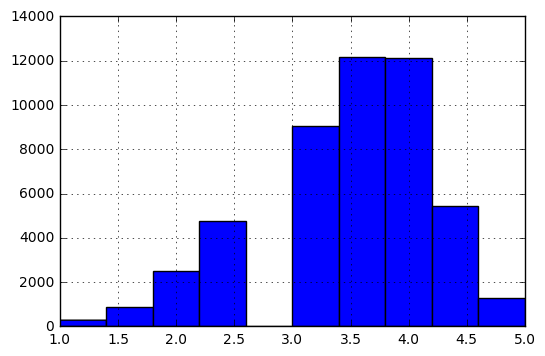

In [30]:
pd.Series(clf.predict(result)).hist()
plt.show()

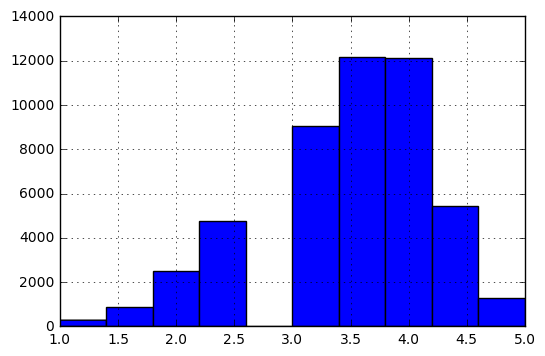

In [31]:
pd.Series(stars).hist()
plt.show()

In [33]:
from sklearn.ensemble        import ExtraTreesRegressor as ETR
from sklearn.metrics         import mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators':[1,10,100]}
clf        = ETR()
acc_scorer = make_scorer(mean_absolute_error,greater_is_better=False)
grid_obj   = GridSearchCV(clf,parameters,scoring=acc_scorer,n_jobs=2,cv=5)
grid_obj   = grid_obj.fit(result,stars)
clf        = grid_obj.best_estimator_

print(grid_obj.best_score_)
print(grid_obj.best_params_)

In [40]:
from sklearn.linear_model import Ridge

parameters = {'alpha':[10]}
clf        = Ridge()
acc_scorer = make_scorer(mean_absolute_error,greater_is_better=False)
grid_obj   = GridSearchCV(clf,parameters,scoring=acc_scorer,n_jobs=2,cv=5)
grid_obj   = grid_obj.fit(result,stars)
clf        = grid_obj.best_estimator_

print(grid_obj.best_score_)
print(grid_obj.best_params_)

-0.571095667188
{'alpha': 10}


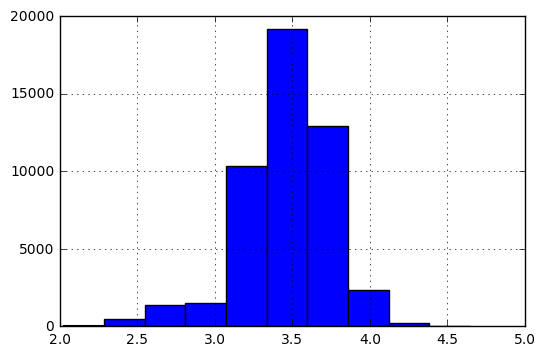

In [41]:
pd.Series(clf.predict(result)).hist()
plt.show()

In [42]:
pd.DataFrame(clf.feature_importances_,result.columns).sort_values(by=0,ascending=False)[0][0:22]

AttributeError: 'Ridge' object has no attribute 'feature_importances_'

In [ ]:
pd.Series((result['latitude']-result['latitude'].min())/(result['latitude'].max()-result['latitude'].min())).plot()
plt.show()

-0.640238218006
{'n_estimators': 10}

In [ ]:
import matplotlib.pyplot as plt

pd.Series(clf.predict(train)).hist()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

pd.Series(ratings).hist()
plt.show()

In [ ]:
from sklearn import neighbors, cross_validation, grid_search

cv = cross_validation.ShuffleSplit(len(y),n_iter=20,test_size=0.2,random_state=42)

param_grid = [{'n_estimators': [300,400,500], 'max_depth': [9,10,11]}]

tune_cv = grid_search.GridSearchCV(scaled_nearest_neighbors,
                                   param_grid=param_grid,
                                   cv=cv,
                                   scoring='r2')

tune_cv.fit(X, y)
tune_cv_accuracy = pd.DataFrame.from_records(
    [(score.parameters['rfr__n_estimators'],
      score.mean_validation_score)
     for score in scaled_nearest_neighbors_cv.grid_scores_], columns=['estimators', 'r2'])

## User Dataset

In [ ]:
!ls -l -h yelp_academic_dataset_review.json

In [ ]:
!head -n 2 yelp_academic_dataset_review.json

In [ ]:
!wc -l yelp_academic_dataset_review.json

In [ ]:
import json

with open('yelp_academic_dataset_review.json') as f:
    business_id = [json.loads(line)['business_id'] for line in f]

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

table = pd.Series(business_id).value_counts()
table_9 = table[table==9]

In [ ]:
for i in table_9.index:
    for

In [ ]:
import json

data  = []
count = 0

with open('yelp_academic_dataset_user.json') as f:
    for line in f:
        data.append(json.loads(line))
        count += 1
        if count > 10000:
            break

In [ ]:
import networkx as nx

G = nx.DiGraph()

In [ ]:
for i in range(10000):
    root = data[i]['user_id']
    G.add_node(root,fans=data[i]['fans'],a_stars=data[i]['average_stars'])
    for friend in data[i]['friends']:
        G.add_edge(friend,root,weight=1.0)

In [ ]:
degree_sequence=sorted(nx.degree(G).values(),reverse=True)

In [ ]:
import matplotlib.pyplot as plt

plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")
plt.show()

In [ ]:
import json
from networkx.readwrite import json_graph
 
for n in G:
    G.node[n]['name'] = n
    
d = json_graph.node_link_data(G)
json.dump(d, open('force.json','w'))

In [ ]:
pos=nx.spring_layout(G)
nx.draw_networkx_nodes(G,pos,node_size=3000)

nx.draw_networkx_edges(G,pos,edgelist=elarge,
                    width=6)
nx.draw_networkx_edges(G,pos,edgelist=esmall,
                    width=6,alpha=0.5,edge_color='b',style='dashed')

# labels
nx.draw_networkx_labels(G,pos,font_size=20,font_family='sans-serif')

plt.axis('off')
plt.savefig("weighted_graph.png") # save as png
plt.show() # display

In [ ]:
from operator import itemgetter

sorted(G.degree_iter(),key=itemgetter(1),reverse=True)[:1]

In [ ]:
G['ZIOCmdFaMIF56FR-nWr_2A']

In [ ]:
dmax=max(degree_sequence)

In [ ]:
plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")

plt.axes([0.45,0.45,0.45,0.45])
Gcc=sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)[0]
pos=nx.spring_layout(Gcc)
plt.axis('off')
nx.draw_networkx_nodes(Gcc,pos,node_size=20)
nx.draw_networkx_edges(Gcc,pos,alpha=0.4)

plt.show()

In [ ]:
!ls

In [ ]:
index = []
count = 0

for i in range(len(data)):
    if data[i]['city'] == 'Phoenix':
        index.append(count)
    count += 1

In [ ]:
import pandas as pd

data_phx = pd.DataFrame(data).iloc[index]



In [ ]:
import gmplot

gmap = gmplot.GoogleMapPlotter(data_phx['latitude'].mean(),data_phx['longitude'].mean(),16)

gmap.scatter(data_phx['latitude'],data_phx['longitude'], 'cornflowerblue', edge_width=10)
#gmap.scatter(more_lats, more_lngs, '#3B0B39', size=40, marker=False)
#gmap.scatter(marker_lats, marker_lngs, 'k', marker=True)
#gmap.heatmap(heat_lats, heat_lngs)

gmap.draw("mymap.html")